In [1]:
# Import other modules not related to PySpark
import os
import sys
import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import math
from IPython.core.interactiveshell import InteractiveShell
from datetime import *
import statistics as stats
# This helps auto print out the items without explixitly using 'print'
InteractiveShell.ast_node_interactivity = "all" 
%matplotlib inline

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions
from pyspark.sql.functions import lit, desc, col, size, array_contains, udf\
, isnan, udf, hour, array_min, array_max, countDistinct
from pyspark.sql.types import *

MAX_MEMORY = '15G'
# Initialize a spark session.
conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()
filename_data = 'the-reddit-covid-dataset-comments.csv'
# Load the main data set into pyspark data frame 
df = spark.read.options(delimiter=",", header=True).csv(filename_data)
# df = spark.read.csv(filename_data)
# df = pd.read_csv(filename_data)
# print(df)
print('Data frame type: ' + str(type(df)))

# df.drop(col('permalink'))

df.show()

Data frame type: <class 'pyspark.sql.dataframe.DataFrame'>
+--------------------+--------------------+--------------------+------------------+--------------+-----------+--------------------+--------------------+---------------+--------------------+
|                type|                  id|        subreddit.id|    subreddit.name|subreddit.nsfw|created_utc|           permalink|                body|      sentiment|               score|
+--------------------+--------------------+--------------------+------------------+--------------+-----------+--------------------+--------------------+---------------+--------------------+
|             comment|             hi1vsag|               2riyy|              nova|         false| 1635206399|https://old.reddi...|When you schedule...|            0.0|                   2|
|             comment|             hi1vs7i|               2qhov|         vancouver|         false| 1635206397|https://old.reddi...|Didn't stop price...|           NULL|             

In [3]:
filtered_data = df.filter(df.type == 'comment')#.\
filtered_data = filtered_data.drop('permalink')
                # filter((df.score.isNull()) | (df.score > 0))

filtered_data = filtered_data.withColumnRenamed('subreddit.nsfw', 'nsfw')
filtered_data = filtered_data.withColumnRenamed('subreddit.id', 'subId')
filtered_data = filtered_data.withColumnRenamed('subreddit.name', 'subName')

filtered_data = filtered_data.filter(col('nsfw') == 'false').drop('nsfw')

filtered_data = filtered_data.withColumn('score', filtered_data['score'].cast('integer'))
filtered_data = filtered_data.withColumn('created_utc', filtered_data['created_utc'].cast('integer'))
filtered_data = filtered_data.withColumn('sentiment', filtered_data['sentiment'].cast('float'))

print('Columns overview')
pd.DataFrame(filtered_data.dtypes, columns = ['Column Name','Data type'])

Columns overview


,Column Name,Data type
0,type,string
1,id,string
2,subId,string
3,subName,string
4,created_utc,int
5,body,string
6,sentiment,float
7,score,int


In [4]:
filtered_data.show()
# print(filtered_data.count())

# print('Columns overview')
# pd.DataFrame(filtered_data.dtypes, columns = ['Column Name','Data type'])

+-------+-------+------+--------------------+-----------+--------------------+---------+-----+
|   type|     id| subId|             subName|created_utc|                body|sentiment|score|
+-------+-------+------+--------------------+-----------+--------------------+---------+-----+
|comment|hi1vsag| 2riyy|                nova| 1635206399|When you schedule...|      0.0|    2|
|comment|hi1vs7i| 2qhov|           vancouver| 1635206397|Didn't stop price...|     NULL| NULL|
|comment|hi1vs5n| 2qwzb|            pregnant| 1635206397|I’m just waiting ...|     NULL| NULL|
|comment|hi1vs5v| 2qixm|            startrek| 1635206397|*The first duty o...|     NULL| NULL|
|comment|hi1vs0l| 2qsf3|             ontario| 1635206395|Compare BC to Ont...|      0.0|   -2|
|comment|hi1vrtk| 2qh0f|       entertainment| 1635206393|"Sheeran didn't m...|     NULL| NULL|
|comment|hi1vrsk| 2qh4r|          conspiracy| 1635206392|I see a lot of po...|     NULL| NULL|
|comment|hi1vrnr|2iokxd|  lockdownskepticism| 1635

In [5]:
from pyspark.ml.feature import Imputer

imputer = Imputer()
imputer.setInputCols(['sentiment', 'score'])
imputer.setOutputCols(["sentiment", "score"])

model = imputer.fit(filtered_data)
model.setInputCols(['sentiment', 'score'])
model.setOutputCols(["sentiment", "score"])

print(model.getStrategy())

filtered_data = model.transform(filtered_data)
filtered_data.show()

Imputer_091ae9d08457

Imputer_091ae9d08457

ImputerModel: uid=Imputer_091ae9d08457, strategy=mean, missingValue=NaN, numInputCols=2, numOutputCols=2

ImputerModel: uid=Imputer_091ae9d08457, strategy=mean, missingValue=NaN, numInputCols=2, numOutputCols=2

mean
+-------+-------+------+--------------------+-----------+--------------------+----------+-----+
|   type|     id| subId|             subName|created_utc|                body| sentiment|score|
+-------+-------+------+--------------------+-----------+--------------------+----------+-----+
|comment|hi1vsag| 2riyy|                nova| 1635206399|When you schedule...|       0.0|    2|
|comment|hi1vs7i| 2qhov|           vancouver| 1635206397|Didn't stop price...|0.19456553|   11|
|comment|hi1vs5n| 2qwzb|            pregnant| 1635206397|I’m just waiting ...|0.19456553|   11|
|comment|hi1vs5v| 2qixm|            startrek| 1635206397|*The first duty o...|0.19456553|   11|
|comment|hi1vs0l| 2qsf3|             ontario| 1635206395|Compare BC to Ont...|       0.0|   -2|
|comment|hi1vrtk| 2qh0f|       entertainment| 1635206393|"Sheeran didn't m...|0.19456553|   11|
|comment|hi1vrsk| 2qh4r|          conspiracy| 1635206392|I see a lot of po...|0.19456553|   11|
|comment|hi1vrnr|2iokxd|  lockdowns

In [6]:
from pyspark.sql.functions import round

filtered_data = filtered_data.withColumn('sentiment', round(col('sentiment'), 4))
filtered_data = filtered_data.drop('type')
filtered_data = filtered_data.drop('id')
filtered_data = filtered_data.drop('subId')
filtered_data.show()

+--------------------+-----------+--------------------+---------+-----+
|             subName|created_utc|                body|sentiment|score|
+--------------------+-----------+--------------------+---------+-----+
|                nova| 1635206399|When you schedule...|      0.0|    2|
|           vancouver| 1635206397|Didn't stop price...|   0.1946|   11|
|            pregnant| 1635206397|I’m just waiting ...|   0.1946|   11|
|            startrek| 1635206397|*The first duty o...|   0.1946|   11|
|             ontario| 1635206395|Compare BC to Ont...|      0.0|   -2|
|       entertainment| 1635206393|"Sheeran didn't m...|   0.1946|   11|
|          conspiracy| 1635206392|I see a lot of po...|   0.1946|   11|
|  lockdownskepticism| 1635206391|And think about h...|  -0.8413|   29|
|                nova| 1635206391|Unfortunately the...|   0.1946|   11|
|         antivaxxers| 1635206391|I don’t know anyo...|  -0.9191|    1|
|          conspiracy| 1635206388|BS. Not a fear ca...|  -0.9625

In [7]:
add_time_filtered = filtered_data.withColumn('created_utc', col('created_utc').cast(TimestampType()).cast(DateType()))
add_time_filtered.show()

+--------------------+-----------+--------------------+---------+-----+
|             subName|created_utc|                body|sentiment|score|
+--------------------+-----------+--------------------+---------+-----+
|                nova| 2021-10-25|When you schedule...|      0.0|    2|
|           vancouver| 2021-10-25|Didn't stop price...|   0.1946|   11|
|            pregnant| 2021-10-25|I’m just waiting ...|   0.1946|   11|
|            startrek| 2021-10-25|*The first duty o...|   0.1946|   11|
|             ontario| 2021-10-25|Compare BC to Ont...|      0.0|   -2|
|       entertainment| 2021-10-25|"Sheeran didn't m...|   0.1946|   11|
|          conspiracy| 2021-10-25|I see a lot of po...|   0.1946|   11|
|  lockdownskepticism| 2021-10-25|And think about h...|  -0.8413|   29|
|                nova| 2021-10-25|Unfortunately the...|   0.1946|   11|
|         antivaxxers| 2021-10-25|I don’t know anyo...|  -0.9191|    1|
|          conspiracy| 2021-10-25|BS. Not a fear ca...|  -0.9625

In [8]:
stat = add_time_filtered.describe()

stat.toPandas()

,summary,subName,body,sentiment,score
0,count,17630498,17630498,17630498,17630498
1,mean,37628.108719247466,NaN,0.1945837887483019,11.494567765470947
2,stddev,447929.00999689393,NaN,42.20464784721198,6152.042184069846
3,min,0000xfyuzn,"&gt; &gt;Okay yeah that is that is crux, tha...",-116.5975,-1247
4,max,zzplant,🪦,119324.0,25829107


In [9]:
import seaborn as sns

boxplot_cols = ['sentiment', 'score']
cleaned_df = add_time_filtered

print(f"Rows count before cleaning: {cleaned_df.count()}")
for column in boxplot_cols:
    # квартили для определения выбросов
    Q1 = cleaned_df.approxQuantile(column, [0.25], 0.01)[0]
    Q3 = cleaned_df.approxQuantile(column, [0.75], 0.01)[0]
    IQR = Q3 - Q1

    # Определение границ для выбросов
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Удаление выбросов
    cleaned_df = cleaned_df.filter((cleaned_df[column] >= lower_bound) & (cleaned_df[column] <= upper_bound))
print(f"Rows count after cleaning: {cleaned_df.count()}")


Rows count before cleaning: 17630498
Rows count after cleaning: 12060553


In [29]:
cleaned_df.show()
cleaned_df_columns = list(cleaned_df.columns)
take_10 = pd.DataFrame(cleaned_df.take(500000), columns=cleaned_df_columns)
take_10.to_csv('take_500K.csv')

+--------------------+-----------+--------------------+---------+-----+
|             subName|created_utc|                body|sentiment|score|
+--------------------+-----------+--------------------+---------+-----+
|                nova| 2021-10-25|When you schedule...|      0.0|    2|
|           vancouver| 2021-10-25|Didn't stop price...|   0.1946|   11|
|            pregnant| 2021-10-25|I’m just waiting ...|   0.1946|   11|
|            startrek| 2021-10-25|*The first duty o...|   0.1946|   11|
|       entertainment| 2021-10-25|"Sheeran didn't m...|   0.1946|   11|
|          conspiracy| 2021-10-25|I see a lot of po...|   0.1946|   11|
|                nova| 2021-10-25|Unfortunately the...|   0.1946|   11|
|      torontoraptors| 2021-10-25|Idk if they have ...|  -0.0516|    3|
|               rvvtf| 2021-10-25|In terms of enrol...|   0.1946|   11|
|         redscarepod| 2021-10-25|Lol it’s kinda fu...|   0.4417|    6|
|          ukpolitics| 2021-10-25|It's the deadlies...|   0.1946

+---------+-----+
|sentiment|count|
+---------+-----+
|  -0.2374|  175|
|   0.2444|  206|
|   0.4791|  220|
|   -0.002|   16|
|   0.3318|  113|
|  -0.2911|  417|
|   0.2886|   69|
|   0.1799|   27|
|   0.2197|  123|
|   0.0202|  294|
|   0.1099|   34|
|  -0.2871|   87|
|   0.3808|   34|
|   0.2462|  409|
|   -0.021|   12|
|   0.4193|   45|
|  -0.2165|   79|
|   0.3599|  188|
|   0.1964|   20|
|  -0.0783|  101|
+---------+-----+
only showing top 20 rows



<Axes: xlabel='sentiment', ylabel='count'>

Text(0.5, 1.0, 'Values frequency of sentiment column')

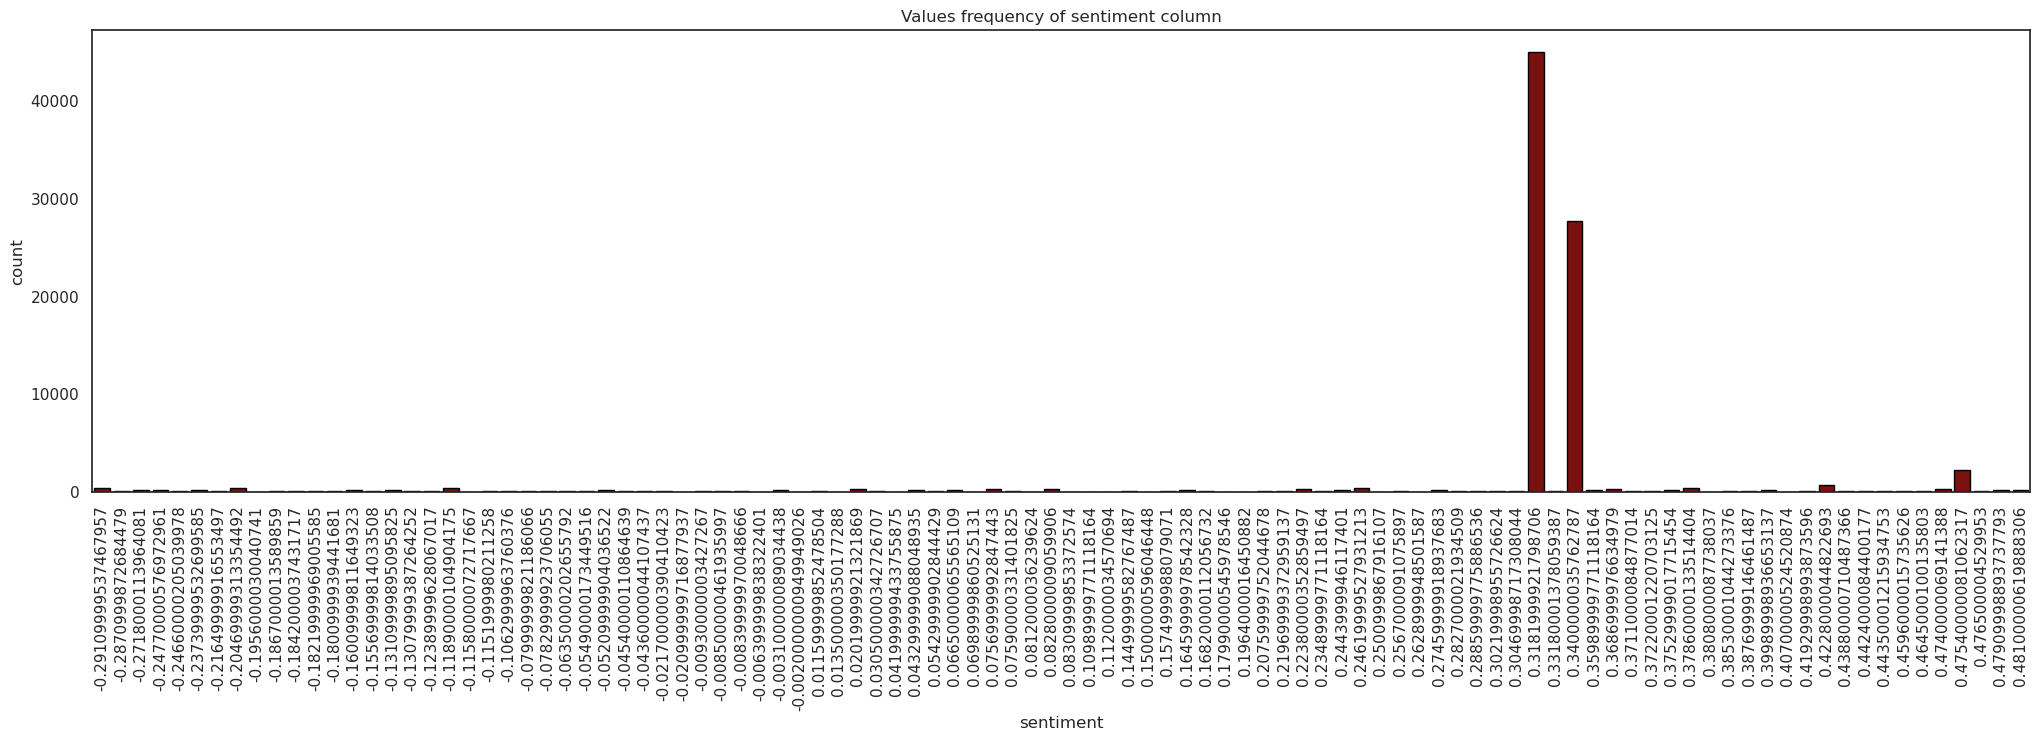

+-----+-------+
|score|  count|
+-----+-------+
|   12|  39320|
|    1|1238598|
|   13|  33983|
|    6| 126779|
|   16|  23447|
|    3| 368541|
|    5| 166420|
|   15|  26176|
|    9|  65332|
|   17|  20865|
|    4| 175195|
|    8|  80295|
|    7|  99463|
|   10|  54312|
|   11|8881222|
|   14|  29797|
|    2| 630808|
+-----+-------+



<Axes: xlabel='score', ylabel='count'>

Text(0.5, 1.0, 'Values frequency of score column')

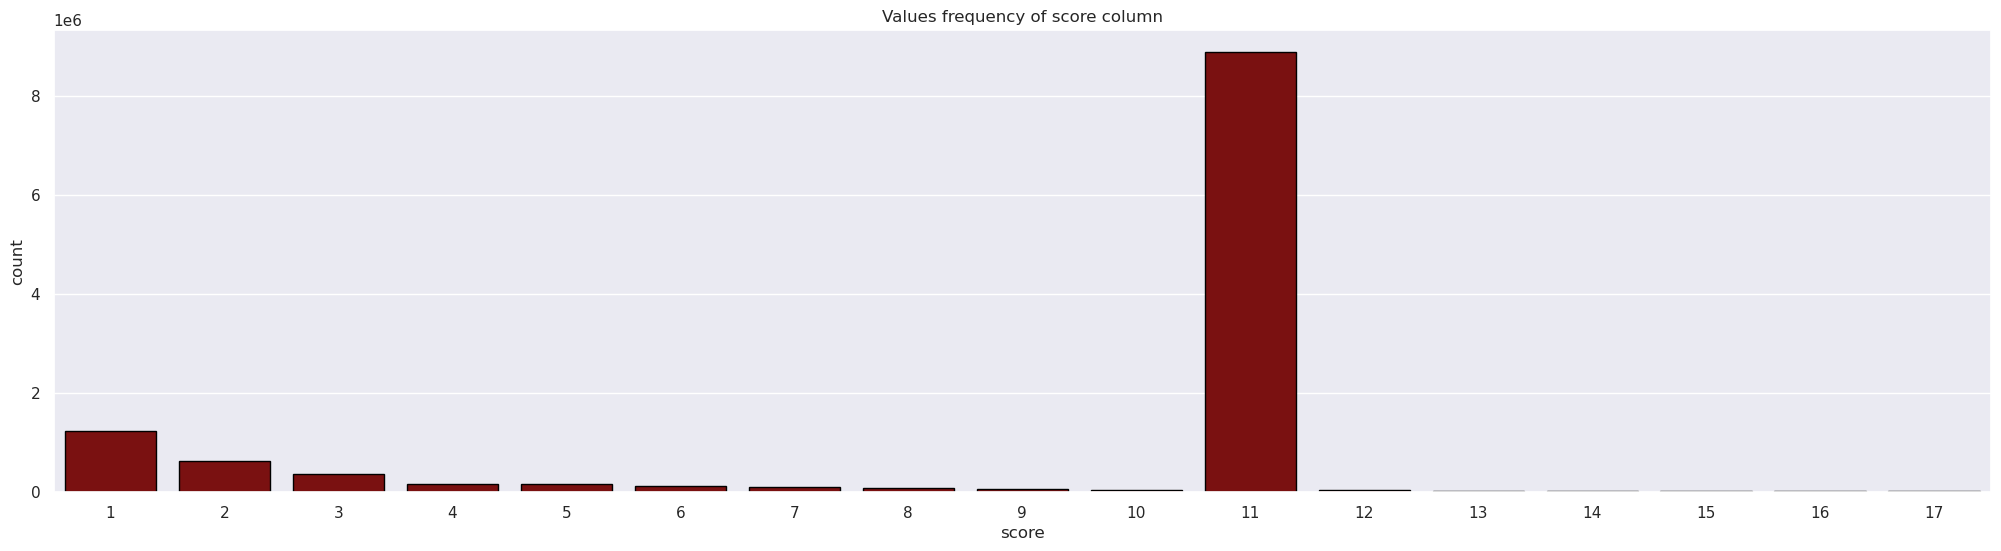

In [14]:
for column in boxplot_cols:
    cleaned_df.groupBy(column).count().show()
    grouped_data = cleaned_df.groupBy(column).count()
    data = grouped_data.limit(100).collect()
    
    pd_data = pd.DataFrame(data, columns=grouped_data.columns)
    pd_colums_names = list(pd_data.columns)

    fig, ax = plt.subplots(1,1)
    sns.set(rc={'figure.figsize':(25,6)})
    sns.barplot(x=pd_colums_names[0], y=pd_colums_names[1], data=pd_data, color='darkred', edgecolor='black')

    if len(str(pd_data[pd_colums_names[0]][0])) >= 4:
        xticks = ax.get_xticks()
        xticklabels = [x.get_text() for x in ax.get_xticklabels()]
        _ = ax.set_xticks(xticks, xticklabels, rotation=90)
    
    plt.title(f"Values frequency of {column} column")
    plt.show()

Calculated quantilies for sentiment
Q1: 0.19460000097751617 
Q3: 0.19460000097751617 
IQR: 0.0 
Lower: 0.19460000097751617 
Upper: 0.19460000097751617


{'whiskers': [<matplotlib.lines.Line2D at 0x7f0798d54310>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0798c57550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0798c04990>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0798c6c710>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0798c6ced0>],
 'means': []}

Text(0.5, 1.0, 'Boxplot for sentiment')

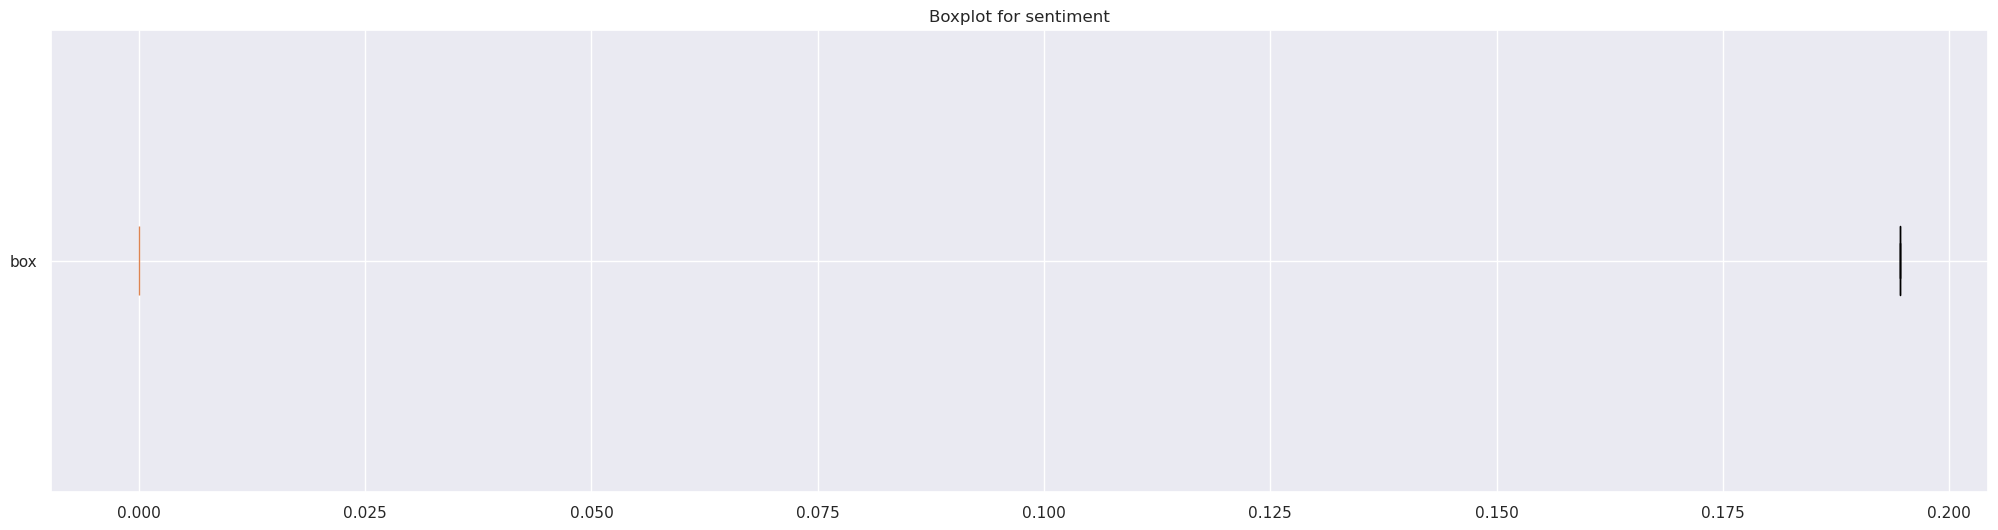

Calculated quantilies for score
Q1: 11 
Q3: 11 
IQR: 0 
Lower: 11.0 
Upper: 11.0


{'whiskers': [<matplotlib.lines.Line2D at 0x7f0798ace750>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0798acf890>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0798a9b010>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0798ae08d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0798ae1090>],
 'means': []}

Text(0.5, 1.0, 'Boxplot for score')

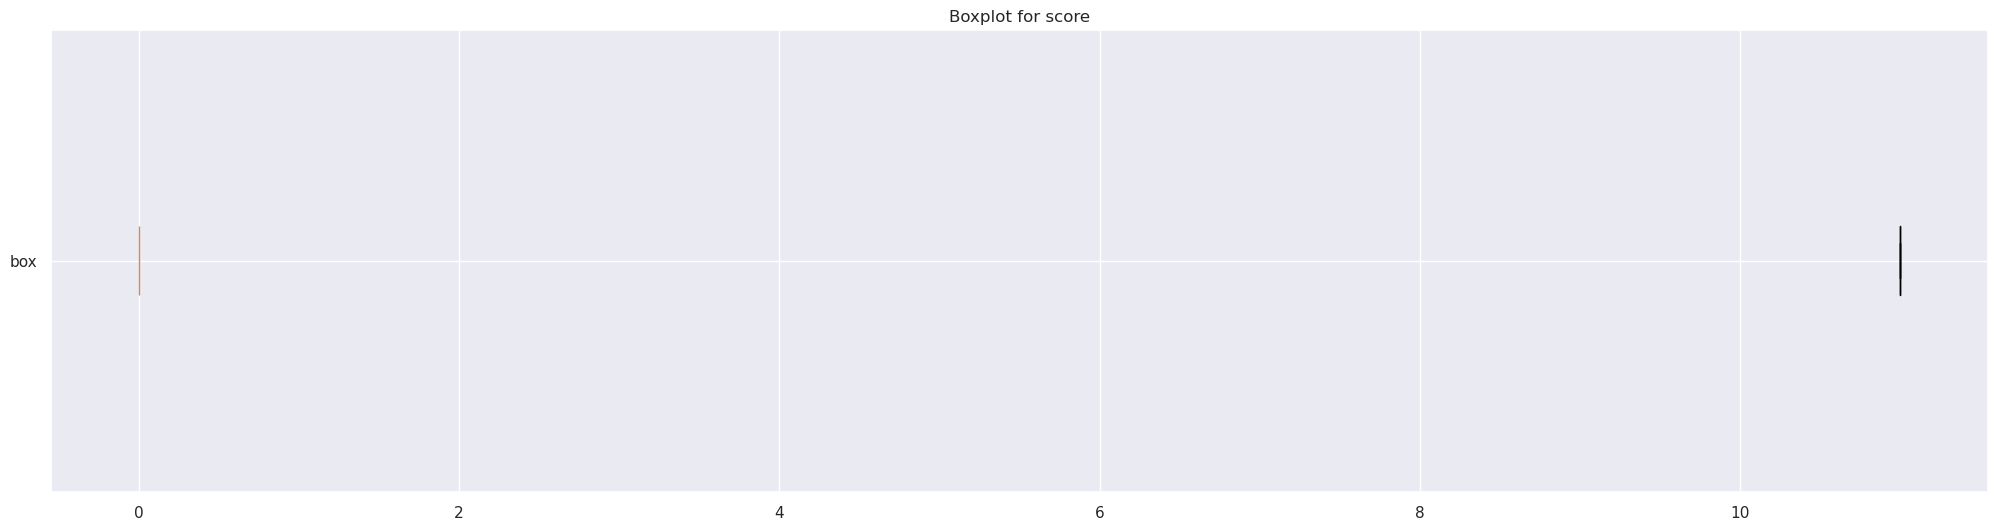

In [11]:
from pyspark.sql.functions import percentile_approx
import numpy as np


for column in boxplot_cols:
    # Собрем данные для усатого ящика  
    precentiles = cleaned_df.select(percentile_approx(column, [0.25, 0.75], 1000000).alias("quantiles")).collect()[0]
    
    # Определим квартили
    Q1 = precentiles[0][0]
    Q3 = precentiles[0][1]
    IQR = Q3 - Q1

    # Определим границы для усатых ящиков
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # lower_bound = Q1 - d_min
    # upper_bound = d_max - Q3
    
    if lower_bound < 0:
        lower_bound = 0
        
    # if upper_bound == 0:
    #     upper_bound = Q3

    
    print(f"Calculated quantilies for {column}\n"
          f"Q1: {Q1} \n"
          f"Q3: {Q3} \n"
          f"IQR: {IQR} \n"
          f"Lower: {lower_bound} \n"
          f"Upper: {upper_bound}")

    item = {"label": 'box', 
            "med": IQR, 
            "q1": Q1, 
            "q3": Q3, 
            "whislo": lower_bound, 
            "whishi": upper_bound, 
            "fliers": []}
    
    #item["cilo"] = 5.3 # not required
    #item["cihi"] = 5.7 # not required
    
    stats = [item]
    
    fig, axes = plt.subplots(1, 1)
    axes.bxp(stats, vert=False, showmeans=False, showfliers=True)
    axes.set_title(f'Boxplot for {column}')
    # y_axis = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    # y_values = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
    # plt.yticks(y_axis, y_values)
    plt.show()

In [12]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler


# Выбираем только числовые признаки
# Создаем вектор из числовых признаков
assembler = VectorAssembler(inputCols=boxplot_cols, outputCol="features")
assembled_df = assembler.transform(cleaned_df)

# Вычисляем корреляцию
correlation_matrix = Correlation.corr(assembled_df, "features").head()

assembled_df.show()

+--------------------+-----------+--------------------+---------+-----+--------------------+
|             subName|created_utc|                body|sentiment|score|            features|
+--------------------+-----------+--------------------+---------+-----+--------------------+
|                nova| 2021-10-25|When you schedule...|      0.0|    2|           [0.0,2.0]|
|           vancouver| 2021-10-25|Didn't stop price...|   0.1946|   11|[0.19460000097751...|
|            pregnant| 2021-10-25|I’m just waiting ...|   0.1946|   11|[0.19460000097751...|
|            startrek| 2021-10-25|*The first duty o...|   0.1946|   11|[0.19460000097751...|
|       entertainment| 2021-10-25|"Sheeran didn't m...|   0.1946|   11|[0.19460000097751...|
|          conspiracy| 2021-10-25|I see a lot of po...|   0.1946|   11|[0.19460000097751...|
|                nova| 2021-10-25|Unfortunately the...|   0.1946|   11|[0.19460000097751...|
|      torontoraptors| 2021-10-25|Idk if they have ...|  -0.0516|    3

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

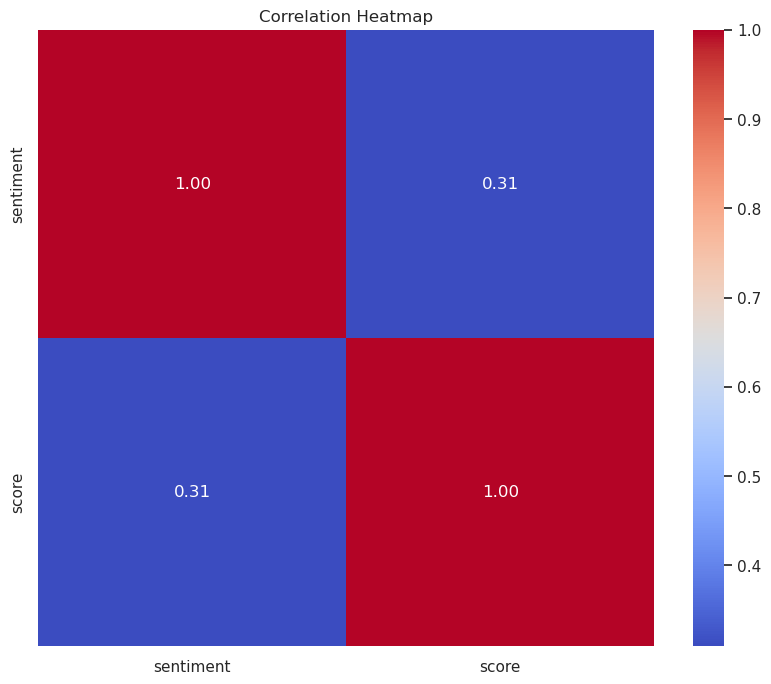

In [13]:
# Извлекаем матрицу корреляции из результатов
corr_matrix = correlation_matrix[0].toArray()

# И heat'em'up!
sns.set(style="white")
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True, xticklabels=boxplot_cols, yticklabels=boxplot_cols)
plt.title("Correlation Heatmap")
plt.show()